In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style


#####################  hyper parameters  ####################

MAX_EPISODES = 3000               # 最大训练代数
MAX_EP_STEPS = 35               # episode最大持续帧数

RENDER = False

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = 'carbinet_pre_FullLoad_1000epi'

LOAD_PRETRAIN = True


ENV_NAME = 'OpenCabinetDrawer-v0'         # 游戏名称
SEED = 123                       # 随机数种子

var = 5
var_low_bound = 0.05

In [5]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                        # learning rate for actor
        self.lr_c = 0.001                                                                        # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.001                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                self.fc1 = nn.Linear(s_dim,256)
                self.fc1.weight.data.normal_(0,0.1)          # initialization
                
                self.fc2 = nn.Linear(256,512)
                self.fc2.weight.data.normal_(0,0.1)
                               
                self.fc3 = nn.Linear(512,256)
                self.fc3.weight.data.normal_(0,0.1)
                
                self.out = nn.Linear(256,a_dim)
                self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = self.fc1(x)
                x = F.relu(x)
                
                x = self.fc2(x)
                x = F.relu(x)
                
                x = self.fc3(x)
                x = F.relu(x)
                
                x = self.out(x)
                x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim):
                super(CNet,self).__init__()
                self.fcs1 = nn.Linear(s_dim,256)
                self.fcs1.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fcs2 = nn.Linear(256,512)
                self.fcs2.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fcs3 = nn.Linear(512,256)
                self.fcs3.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01) 
                
                self.fca1 = nn.Linear(a_dim,256)
                self.fca1.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.fca2 = nn.Linear(256,512)
                self.fca2.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)              
                
                self.fca3 = nn.Linear(512,256)
                self.fca3.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
                
                self.out = nn.Linear(256,1)
                self.out.weight.data.normal_(0,0.1)          # initialization
                #self.fcs1.weight.data.fill_(-0.01)
            def forward(self,s,a):
                x = self.fcs1(s)                              # 输入状态
                x = F.relu(x)
                
                x = self.fcs2(x)
                x = F.relu(x)
                
                x = self.fcs3(x)
                x = F.relu(x) 
                
                y = self.fca1(a)                              # 输入动作
                y = F.relu(y)
                
                y = self.fca2(y)                              
                y = F.relu(y)
                
                y = self.fca3(y)                              
                y = F.relu(y)
                
                net = F.relu(x+y)
                actions_value = self.out(net)                # 给出V(s,a)
                return actions_value

        self.Actor_eval = ANet(s_dim, a_dim, a_bound)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print('choose action: ',self.Actor_eval(s))
        #print('choose action 0 : ', self.Actor_eval(s)[0])
        #print('forward: ',self.Actor_eval.forward(s))
        return self.Actor_eval(s)[0].detach()                # detach()不需要计算梯度 #用forward等价（应该

    def learn(self):

        for x in self.Actor_target.state_dict().keys():#更新target network
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state
        
        
        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  # loss=-q=-ce(s,ae(s))更新ae   ae(s)=a   ae(s_)=a_
        # 如果 a是一个正确的行为的话，那么它的Q应该更贴近0
        loss_a = -torch.mean(q)            #一个batch输入进qu，有好多个q所以要做平均
        #print('q: ',q)
        #print('loss_a: ',loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()
        
        
        a_ = self.Actor_target(bs_)      # 这个网络不及时更新参数, 用于预测 Critic 的 Q_target 中的 action
        q_ = self.Critic_target(bs_,a_)  # 这个网络不及时更新参数, 用于给出 Actor 更新参数时的 Gradient ascent 强度
        q_target = br + self.gamma * q_  # q_target = 负的
        #print('q_target: ', q_target)
        #print('Reward: ', br)
        #print('q_: ', q_)
        q_v = self.Critic_eval(bs,ba)
        #print('q_v: ', q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error = R + self.gamma * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        # print('td error: ', torch.mean(td_error))
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()
        
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                               # 指示sample位置的指针+1
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def save(self,folder_name):
    
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        plt.scatter(x, y)
        plt.savefig('./DPG model/' + folder_name + '/scatter.png')
        plt.plot(x, y)
        plt.savefig('./DPG model/' + folder_name + '/plot.png')
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)
        
    def load_pretrain(self):    
        ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_eval.eval()
        ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
        ddpg.Actor_target.eval() 
        ddpg.Critic_eval.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_eval.eval()
        ddpg.Critic_target.load_state_dict(torch.load('./DPG model/pretrain/Critic_eval.h5f'))
        ddpg.Critic_target.eval()   

In [6]:
###############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                         # 动作取值区间,对称区间，故只取上界
ddpg = DDPG(a_dim, s_dim, a_bound)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.load_pretrain()


if LOAD_MODEL or LOAD_MEM:
    var = 0.1

if LOAD_PRETRAIN:
    var = 0.2

    
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    s = env.reset(level = 1)
    ep_reward = 0

    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        
        if info_.get('success'):
            print('SUCCESS')
            r += 100 #+200
        
        r += 10
        r = r * 200
        r+= 200
        #print(r)
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化
    
        
        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS -1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward/j), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward/j)
            
            #if ddpg.pointer > ddpg.memory_capacity and done:
                #RENDER = True
            
            break
               
print('Running time: ', time.time() - t1)

Episode: 0  Reward: -133 Explore: 0.20
Episode: 1  Reward: -227 Explore: 0.20
Episode: 2  Reward: -122 Explore: 0.20
Episode: 3  Reward: -188 Explore: 0.20
Episode: 4  Reward: -228 Explore: 0.20
Episode: 5  Reward: -196 Explore: 0.20
Episode: 6  Reward: -130 Explore: 0.20
Episode: 7  Reward: -179 Explore: 0.20
Episode: 8  Reward: -164 Explore: 0.20
Episode: 9  Reward: -177 Explore: 0.20
Episode: 10  Reward: -211 Explore: 0.20
Episode: 11  Reward: -127 Explore: 0.20
Episode: 12  Reward: -151 Explore: 0.20
Episode: 13  Reward: -102 Explore: 0.20
Episode: 14  Reward: -201 Explore: 0.20
Episode: 15  Reward: -87 Explore: 0.20
Episode: 16  Reward: -115 Explore: 0.20
Episode: 17  Reward: -171 Explore: 0.20
Episode: 18  Reward: -158 Explore: 0.20
Episode: 19  Reward: -168 Explore: 0.20
Episode: 20  Reward: -110 Explore: 0.20
Episode: 21  Reward: -169 Explore: 0.20
Episode: 22  Reward: -194 Explore: 0.20
Episode: 23  Reward: -100 Explore: 0.20
Episode: 24  Reward: -30 Explore: 0.20
Episode: 25 

Episode: 204  Reward: -73 Explore: 0.20
Episode: 205  Reward: -157 Explore: 0.20
Episode: 206  Reward: -151 Explore: 0.20
Episode: 207  Reward: -27 Explore: 0.20
Episode: 208  Reward: -134 Explore: 0.20
Episode: 209  Reward: -231 Explore: 0.20
Episode: 210  Reward: -109 Explore: 0.20
Episode: 211  Reward: -100 Explore: 0.20
Episode: 212  Reward: -166 Explore: 0.20
Episode: 213  Reward: -130 Explore: 0.20
Episode: 214  Reward: -124 Explore: 0.20
Episode: 215  Reward: -149 Explore: 0.20
Episode: 216  Reward: -161 Explore: 0.20
Episode: 217  Reward: -98 Explore: 0.20
Episode: 218  Reward: -127 Explore: 0.20
Episode: 219  Reward: -115 Explore: 0.20
Episode: 220  Reward: -118 Explore: 0.20
Episode: 221  Reward: -225 Explore: 0.20
Episode: 222  Reward: -70 Explore: 0.20
Episode: 223  Reward: -104 Explore: 0.20
Episode: 224  Reward: -77 Explore: 0.20
Episode: 225  Reward: -142 Explore: 0.20
Episode: 226  Reward: -97 Explore: 0.20
Episode: 227  Reward: -142 Explore: 0.20
Episode: 228  Reward: 

Episode: 405  Reward: -143 Explore: 0.05
Episode: 406  Reward: -116 Explore: 0.05
Episode: 407  Reward: -134 Explore: 0.05
Episode: 408  Reward: -113 Explore: 0.05
Episode: 409  Reward: -167 Explore: 0.05
Episode: 410  Reward: -115 Explore: 0.05
Episode: 411  Reward: -148 Explore: 0.05
SUCCESS
Episode: 412  Reward: 1195 Explore: 0.05
Episode: 413  Reward: -146 Explore: 0.05
SUCCESS
Episode: 414  Reward: 1413 Explore: 0.05
Episode: 415  Reward: -140 Explore: 0.05
Episode: 416  Reward: -151 Explore: 0.05
Episode: 417  Reward: -132 Explore: 0.05
Episode: 418  Reward: -102 Explore: 0.05
Episode: 419  Reward: -97 Explore: 0.05
Episode: 420  Reward: -120 Explore: 0.05
Episode: 421  Reward: -140 Explore: 0.05
Episode: 422  Reward: -147 Explore: 0.05
Episode: 423  Reward: -105 Explore: 0.05
Episode: 424  Reward: -126 Explore: 0.05
Episode: 425  Reward: -141 Explore: 0.05
Episode: 426  Reward: -167 Explore: 0.05
Episode: 427  Reward: -149 Explore: 0.05
Episode: 428  Reward: -79 Explore: 0.05
Ep

Episode: 604  Reward: -133 Explore: 0.05
Episode: 605  Reward: -148 Explore: 0.05
Episode: 606  Reward: -118 Explore: 0.05
Episode: 607  Reward: -156 Explore: 0.05
Episode: 608  Reward: -102 Explore: 0.05
Episode: 609  Reward: -108 Explore: 0.05
Episode: 610  Reward: -148 Explore: 0.05
Episode: 611  Reward: -88 Explore: 0.05
Episode: 612  Reward: -136 Explore: 0.05
Episode: 613  Reward: -121 Explore: 0.05
Episode: 614  Reward: -152 Explore: 0.05
Episode: 615  Reward: -121 Explore: 0.05
Episode: 616  Reward: -180 Explore: 0.05
Episode: 617  Reward: -154 Explore: 0.05
Episode: 618  Reward: -124 Explore: 0.05
Episode: 619  Reward: -110 Explore: 0.05
Episode: 620  Reward: -140 Explore: 0.05
Episode: 621  Reward: -65 Explore: 0.05
Episode: 622  Reward: -118 Explore: 0.05
Episode: 623  Reward: -128 Explore: 0.05
Episode: 624  Reward: -113 Explore: 0.05
Episode: 625  Reward: -150 Explore: 0.05
Episode: 626  Reward: -156 Explore: 0.05
Episode: 627  Reward: -143 Explore: 0.05
Episode: 628  Rewa

Episode: 803  Reward: -153 Explore: 0.05
SUCCESS
Episode: 804  Reward: 1302 Explore: 0.05
Episode: 805  Reward: -156 Explore: 0.05
Episode: 806  Reward: -78 Explore: 0.05
Episode: 807  Reward: -150 Explore: 0.05
Episode: 808  Reward: -155 Explore: 0.05
Episode: 809  Reward: -117 Explore: 0.05
Episode: 810  Reward: -118 Explore: 0.05
Episode: 811  Reward: -167 Explore: 0.05
Episode: 812  Reward: -118 Explore: 0.05
Episode: 813  Reward: -161 Explore: 0.05
Episode: 814  Reward: -104 Explore: 0.05
Episode: 815  Reward: -139 Explore: 0.05
Episode: 816  Reward: -150 Explore: 0.05
Episode: 817  Reward: -120 Explore: 0.05
Episode: 818  Reward: -104 Explore: 0.05
Episode: 819  Reward: -126 Explore: 0.05
Episode: 820  Reward: -132 Explore: 0.05
Episode: 821  Reward: -156 Explore: 0.05
Episode: 822  Reward: -156 Explore: 0.05
Episode: 823  Reward: -154 Explore: 0.05
Episode: 824  Reward: -102 Explore: 0.05
Episode: 825  Reward: -109 Explore: 0.05
Episode: 826  Reward: -131 Explore: 0.05
Episode: 

Episode: 1003  Reward: -98 Explore: 0.05
Episode: 1004  Reward: -122 Explore: 0.05
Episode: 1005  Reward: -146 Explore: 0.05
Episode: 1006  Reward: -130 Explore: 0.05
Episode: 1007  Reward: -155 Explore: 0.05
Episode: 1008  Reward: -157 Explore: 0.05
Episode: 1009  Reward: -140 Explore: 0.05
Episode: 1010  Reward: -145 Explore: 0.05
Episode: 1011  Reward: -141 Explore: 0.05
Episode: 1012  Reward: -139 Explore: 0.05
Episode: 1013  Reward: -161 Explore: 0.05
Episode: 1014  Reward: -162 Explore: 0.05
Episode: 1015  Reward: -163 Explore: 0.05
Episode: 1016  Reward: -127 Explore: 0.05
Episode: 1017  Reward: -140 Explore: 0.05
Episode: 1018  Reward: -128 Explore: 0.05
Episode: 1019  Reward: -168 Explore: 0.05
Episode: 1020  Reward: -100 Explore: 0.05
Episode: 1021  Reward: -123 Explore: 0.05
Episode: 1022  Reward: -166 Explore: 0.05
Episode: 1023  Reward: -128 Explore: 0.05
Episode: 1024  Reward: -169 Explore: 0.05
Episode: 1025  Reward: -133 Explore: 0.05
Episode: 1026  Reward: -116 Explore

Episode: 1199  Reward: -156 Explore: 0.05
Episode: 1200  Reward: -90 Explore: 0.05
Episode: 1201  Reward: -140 Explore: 0.05
Episode: 1202  Reward: -141 Explore: 0.05
Episode: 1203  Reward: -113 Explore: 0.05
Episode: 1204  Reward: -121 Explore: 0.05
Episode: 1205  Reward: -174 Explore: 0.05
Episode: 1206  Reward: -155 Explore: 0.05
Episode: 1207  Reward: -94 Explore: 0.05
Episode: 1208  Reward: -106 Explore: 0.05
Episode: 1209  Reward: -156 Explore: 0.05
Episode: 1210  Reward: -124 Explore: 0.05
SUCCESS
Episode: 1211  Reward: 1204 Explore: 0.05
Episode: 1212  Reward: -129 Explore: 0.05
Episode: 1213  Reward: -128 Explore: 0.05
Episode: 1214  Reward: -97 Explore: 0.05
Episode: 1215  Reward: -95 Explore: 0.05
Episode: 1216  Reward: -130 Explore: 0.05
Episode: 1217  Reward: -99 Explore: 0.05
Episode: 1218  Reward: -128 Explore: 0.05
Episode: 1219  Reward: -114 Explore: 0.05
Episode: 1220  Reward: -147 Explore: 0.05
Episode: 1221  Reward: -145 Explore: 0.05
Episode: 1222  Reward: -152 Exp

Episode: 1394  Reward: -95 Explore: 0.05
Episode: 1395  Reward: -116 Explore: 0.05
Episode: 1396  Reward: -172 Explore: 0.05
Episode: 1397  Reward: -117 Explore: 0.05
Episode: 1398  Reward: -134 Explore: 0.05
Episode: 1399  Reward: -156 Explore: 0.05
Episode: 1400  Reward: -166 Explore: 0.05
Episode: 1401  Reward: -174 Explore: 0.05
Episode: 1402  Reward: -135 Explore: 0.05
Episode: 1403  Reward: -118 Explore: 0.05
Episode: 1404  Reward: -139 Explore: 0.05
Episode: 1405  Reward: -123 Explore: 0.05
Episode: 1406  Reward: -119 Explore: 0.05
Episode: 1407  Reward: -129 Explore: 0.05
Episode: 1408  Reward: -160 Explore: 0.05
Episode: 1409  Reward: -135 Explore: 0.05
Episode: 1410  Reward: -137 Explore: 0.05
Episode: 1411  Reward: -101 Explore: 0.05
Episode: 1412  Reward: -129 Explore: 0.05
Episode: 1413  Reward: -123 Explore: 0.05
Episode: 1414  Reward: -122 Explore: 0.05
Episode: 1415  Reward: -153 Explore: 0.05
Episode: 1416  Reward: -149 Explore: 0.05
Episode: 1417  Reward: -142 Explore

Episode: 1589  Reward: -97 Explore: 0.05
Episode: 1590  Reward: -162 Explore: 0.05
Episode: 1591  Reward: -154 Explore: 0.05
Episode: 1592  Reward: -135 Explore: 0.05
Episode: 1593  Reward: -101 Explore: 0.05
Episode: 1594  Reward: -126 Explore: 0.05
Episode: 1595  Reward: -107 Explore: 0.05
Episode: 1596  Reward: -170 Explore: 0.05
Episode: 1597  Reward: -144 Explore: 0.05
Episode: 1598  Reward: -138 Explore: 0.05
Episode: 1599  Reward: -119 Explore: 0.05
SUCCESS
Episode: 1600  Reward: 1259 Explore: 0.05
Episode: 1601  Reward: -145 Explore: 0.05
Episode: 1602  Reward: -110 Explore: 0.05
Episode: 1603  Reward: -131 Explore: 0.05
Episode: 1604  Reward: -174 Explore: 0.05
Episode: 1605  Reward: -128 Explore: 0.05
Episode: 1606  Reward: -124 Explore: 0.05
Episode: 1607  Reward: -103 Explore: 0.05
Episode: 1608  Reward: -147 Explore: 0.05
Episode: 1609  Reward: -158 Explore: 0.05
Episode: 1610  Reward: -165 Explore: 0.05
Episode: 1611  Reward: -165 Explore: 0.05
Episode: 1612  Reward: -150

Episode: 1784  Reward: -143 Explore: 0.05
Episode: 1785  Reward: -154 Explore: 0.05
Episode: 1786  Reward: -148 Explore: 0.05
Episode: 1787  Reward: -168 Explore: 0.05
Episode: 1788  Reward: -122 Explore: 0.05
Episode: 1789  Reward: -129 Explore: 0.05
Episode: 1790  Reward: -136 Explore: 0.05
Episode: 1791  Reward: -157 Explore: 0.05
Episode: 1792  Reward: -151 Explore: 0.05
Episode: 1793  Reward: -146 Explore: 0.05
Episode: 1794  Reward: -124 Explore: 0.05
Episode: 1795  Reward: -157 Explore: 0.05
Episode: 1796  Reward: -121 Explore: 0.05
Episode: 1797  Reward: -144 Explore: 0.05
Episode: 1798  Reward: -117 Explore: 0.05
Episode: 1799  Reward: -151 Explore: 0.05
Episode: 1800  Reward: -133 Explore: 0.05
Episode: 1801  Reward: -126 Explore: 0.05
Episode: 1802  Reward: -159 Explore: 0.05
Episode: 1803  Reward: -142 Explore: 0.05
Episode: 1804  Reward: -115 Explore: 0.05
Episode: 1805  Reward: -159 Explore: 0.05
Episode: 1806  Reward: -110 Explore: 0.05
Episode: 1807  Reward: -126 Explor

Episode: 1979  Reward: -129 Explore: 0.05
Episode: 1980  Reward: -145 Explore: 0.05
Episode: 1981  Reward: -153 Explore: 0.05
Episode: 1982  Reward: -111 Explore: 0.05
Episode: 1983  Reward: -127 Explore: 0.05
Episode: 1984  Reward: -163 Explore: 0.05
Episode: 1985  Reward: -147 Explore: 0.05
Episode: 1986  Reward: -143 Explore: 0.05
Episode: 1987  Reward: -158 Explore: 0.05
Episode: 1988  Reward: -119 Explore: 0.05
Episode: 1989  Reward: -116 Explore: 0.05
Episode: 1990  Reward: -118 Explore: 0.05
Episode: 1991  Reward: -138 Explore: 0.05
Episode: 1992  Reward: -124 Explore: 0.05
Episode: 1993  Reward: -105 Explore: 0.05
Episode: 1994  Reward: -149 Explore: 0.05
Episode: 1995  Reward: -122 Explore: 0.05
Episode: 1996  Reward: -156 Explore: 0.05
Episode: 1997  Reward: -149 Explore: 0.05
Episode: 1998  Reward: -144 Explore: 0.05
Episode: 1999  Reward: -121 Explore: 0.05
Episode: 2000  Reward: -167 Explore: 0.05
Episode: 2001  Reward: -154 Explore: 0.05
Episode: 2002  Reward: -122 Explor

Episode: 2174  Reward: -189 Explore: 0.05
Episode: 2175  Reward: -140 Explore: 0.05
Episode: 2176  Reward: -129 Explore: 0.05
Episode: 2177  Reward: -142 Explore: 0.05
Episode: 2178  Reward: -66 Explore: 0.05
Episode: 2179  Reward: -163 Explore: 0.05
Episode: 2180  Reward: -135 Explore: 0.05
Episode: 2181  Reward: -159 Explore: 0.05
Episode: 2182  Reward: -142 Explore: 0.05
Episode: 2183  Reward: -149 Explore: 0.05
Episode: 2184  Reward: -119 Explore: 0.05
Episode: 2185  Reward: -106 Explore: 0.05
Episode: 2186  Reward: -146 Explore: 0.05
Episode: 2187  Reward: -139 Explore: 0.05
Episode: 2188  Reward: -57 Explore: 0.05
Episode: 2189  Reward: -139 Explore: 0.05
Episode: 2190  Reward: -107 Explore: 0.05
Episode: 2191  Reward: -104 Explore: 0.05
Episode: 2192  Reward: -150 Explore: 0.05
Episode: 2193  Reward: -139 Explore: 0.05
Episode: 2194  Reward: -165 Explore: 0.05
Episode: 2195  Reward: -153 Explore: 0.05
Episode: 2196  Reward: -123 Explore: 0.05
Episode: 2197  Reward: -103 Explore:

Episode: 2369  Reward: -123 Explore: 0.05
Episode: 2370  Reward: -139 Explore: 0.05
Episode: 2371  Reward: -139 Explore: 0.05
Episode: 2372  Reward: -135 Explore: 0.05
Episode: 2373  Reward: -88 Explore: 0.05
Episode: 2374  Reward: -122 Explore: 0.05
SUCCESS
Episode: 2375  Reward: 1199 Explore: 0.05
Episode: 2376  Reward: -137 Explore: 0.05
Episode: 2377  Reward: -128 Explore: 0.05
Episode: 2378  Reward: -146 Explore: 0.05
Episode: 2379  Reward: -104 Explore: 0.05
Episode: 2380  Reward: -154 Explore: 0.05
Episode: 2381  Reward: -151 Explore: 0.05
Episode: 2382  Reward: -171 Explore: 0.05
Episode: 2383  Reward: -132 Explore: 0.05
Episode: 2384  Reward: -153 Explore: 0.05
Episode: 2385  Reward: -97 Explore: 0.05
Episode: 2386  Reward: -140 Explore: 0.05
Episode: 2387  Reward: -119 Explore: 0.05
SUCCESS
Episode: 2388  Reward: 1365 Explore: 0.05
Episode: 2389  Reward: -162 Explore: 0.05
Episode: 2390  Reward: -118 Explore: 0.05
Episode: 2391  Reward: -108 Explore: 0.05
Episode: 2392  Rewar

Episode: 2564  Reward: -161 Explore: 0.05
Episode: 2565  Reward: -85 Explore: 0.05
Episode: 2566  Reward: -124 Explore: 0.05
Episode: 2567  Reward: -156 Explore: 0.05
Episode: 2568  Reward: -122 Explore: 0.05
Episode: 2569  Reward: -107 Explore: 0.05
Episode: 2570  Reward: -146 Explore: 0.05
Episode: 2571  Reward: -120 Explore: 0.05
Episode: 2572  Reward: -129 Explore: 0.05
Episode: 2573  Reward: -140 Explore: 0.05
Episode: 2574  Reward: -131 Explore: 0.05
Episode: 2575  Reward: -103 Explore: 0.05
Episode: 2576  Reward: -141 Explore: 0.05
Episode: 2577  Reward: -117 Explore: 0.05
Episode: 2578  Reward: -147 Explore: 0.05
Episode: 2579  Reward: -104 Explore: 0.05
Episode: 2580  Reward: -115 Explore: 0.05
Episode: 2581  Reward: -160 Explore: 0.05
Episode: 2582  Reward: -114 Explore: 0.05
Episode: 2583  Reward: -146 Explore: 0.05
Episode: 2584  Reward: -108 Explore: 0.05
Episode: 2585  Reward: -100 Explore: 0.05
Episode: 2586  Reward: -154 Explore: 0.05
Episode: 2587  Reward: -127 Explore

Episode: 2759  Reward: -128 Explore: 0.05
Episode: 2760  Reward: -113 Explore: 0.05
Episode: 2761  Reward: -138 Explore: 0.05
Episode: 2762  Reward: -128 Explore: 0.05
Episode: 2763  Reward: -161 Explore: 0.05
Episode: 2764  Reward: -148 Explore: 0.05
Episode: 2765  Reward: -155 Explore: 0.05
Episode: 2766  Reward: -105 Explore: 0.05
Episode: 2767  Reward: -108 Explore: 0.05
Episode: 2768  Reward: -104 Explore: 0.05
Episode: 2769  Reward: -128 Explore: 0.05
Episode: 2770  Reward: -157 Explore: 0.05
Episode: 2771  Reward: -129 Explore: 0.05
Episode: 2772  Reward: -149 Explore: 0.05
Episode: 2773  Reward: -162 Explore: 0.05
Episode: 2774  Reward: -121 Explore: 0.05
Episode: 2775  Reward: -165 Explore: 0.05
Episode: 2776  Reward: -131 Explore: 0.05
Episode: 2777  Reward: -127 Explore: 0.05
Episode: 2778  Reward: -120 Explore: 0.05
Episode: 2779  Reward: -149 Explore: 0.05
Episode: 2780  Reward: -73 Explore: 0.05
SUCCESS
Episode: 2781  Reward: 1357 Explore: 0.05
Episode: 2782  Reward: -118

Episode: 2954  Reward: -131 Explore: 0.05
Episode: 2955  Reward: -111 Explore: 0.05
Episode: 2956  Reward: -123 Explore: 0.05
Episode: 2957  Reward: -122 Explore: 0.05
Episode: 2958  Reward: -142 Explore: 0.05
Episode: 2959  Reward: -155 Explore: 0.05
Episode: 2960  Reward: -100 Explore: 0.05
Episode: 2961  Reward: -119 Explore: 0.05
Episode: 2962  Reward: -136 Explore: 0.05
Episode: 2963  Reward: -107 Explore: 0.05
Episode: 2964  Reward: -168 Explore: 0.05
Episode: 2965  Reward: -163 Explore: 0.05
Episode: 2966  Reward: -135 Explore: 0.05
SUCCESS
Episode: 2967  Reward: 1247 Explore: 0.05
Episode: 2968  Reward: -166 Explore: 0.05
Episode: 2969  Reward: -116 Explore: 0.05
Episode: 2970  Reward: -104 Explore: 0.05
Episode: 2971  Reward: -121 Explore: 0.05
Episode: 2972  Reward: -116 Explore: 0.05
Episode: 2973  Reward: -102 Explore: 0.05
Episode: 2974  Reward: -103 Explore: 0.05
Episode: 2975  Reward: -130 Explore: 0.05
Episode: 2976  Reward: -165 Explore: 0.05
Episode: 2977  Reward: -91

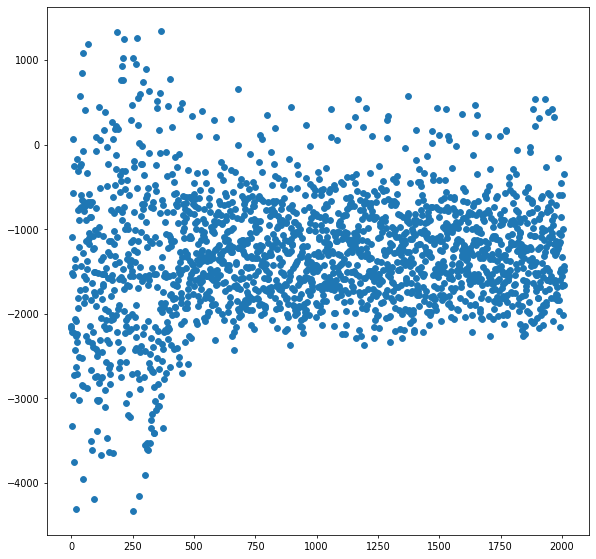

In [14]:
ddpg.plot_rewards(scatter = True)

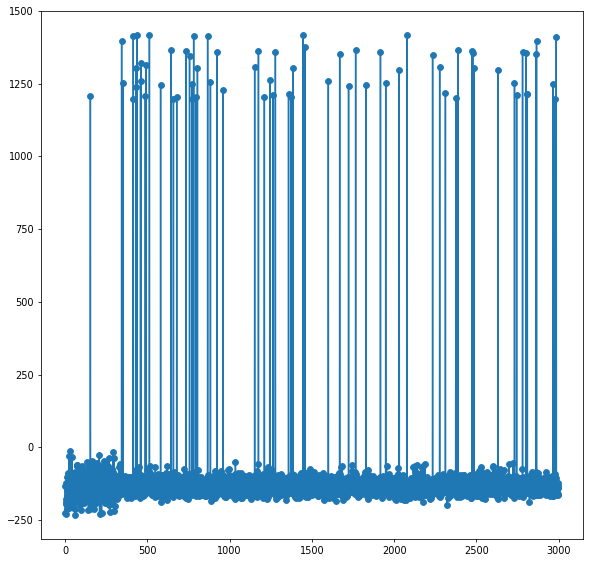

In [7]:
ddpg.save('carbinet_pre-loaded_3000epi')

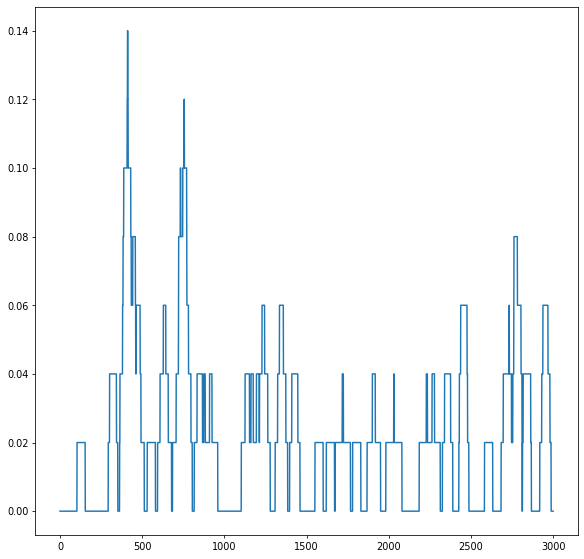

In [9]:
data = pd.read_csv('./DPG model/carbinet_pre-loaded_3000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

z = np.zeros(len(y)+50)
for i in range(len(y)):
    if y[i] >= 10:
        z[i] = 1
        
z_ = np.zeros(len(y))

for i in range(len(z_)):
    for j in range(50):
        z_[i] += z[i+j]
    z_[i] = z_[i] / 50

plt.figure(figsize=(10, 10), dpi=70)
plt.plot(x, z_)
plt.show()

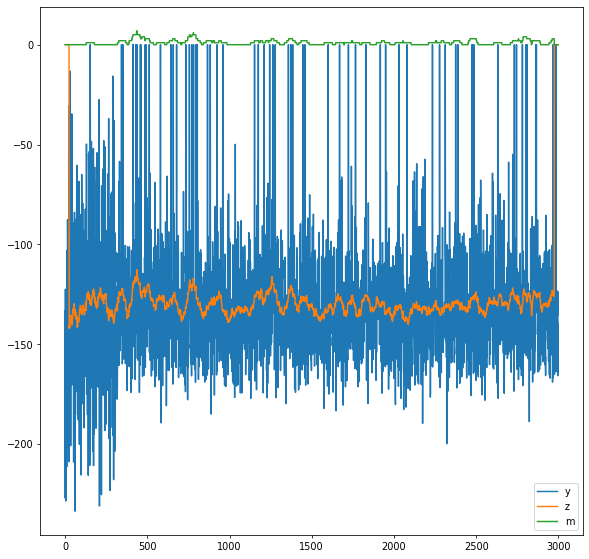

maximum success rate:  0.14
maximum mean rewards:  0.0


In [46]:
data = pd.read_csv('./DPG model/carbinet_pre-loaded_3000epi/Rewards.csv')
y = np.array(data).squeeze()
x = range(y.shape[0])

size = 50

z = np.zeros(len(y))
m = np.zeros(len(y))

for i in range(len(y)):
    if y[i] >= 10:
        y[i] = 0
        
for i in range(len(y)):
    
    if i > (size/2 -1) and i < (len(y) - size/2):  
        for j in range(size):
            z[i] += y[i + j - int(size/2)]  #平均reward
            
            if(y[i + j - int(size/2)] == 0):
                m[i] += 1                  #success rate
            
                                   
            
        z[i] = z[i] / size
        m[i] = m[i]
        

    
    
plt.figure(figsize=(10, 10), dpi=70)

plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, m)

plt.legend(['y','z','m'])
plt.show()

print('maximum success rate: ', max(m)/50)
print('maximum mean rewards: ', max(z))


In [8]:
done

True